# Objective
Write functions for building the required feature matrix for the input to the learning algorithm

In [43]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa as lr
import pyroomacoustics as pra
from IPython.display import Audio
from librosa import display, feature


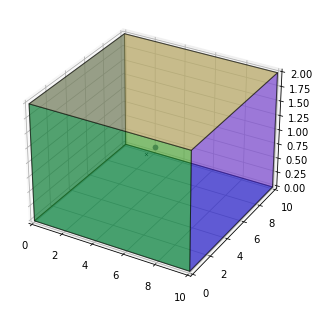

In [3]:
# The desired reverberation time and dimensions of the room
room_dim = [10, 10, 2]  # meters
sr = 44100

#define materials
m = pra.make_materials(
    ceiling="hard_surface",
    floor="carpet_soft_10mm",
    east="gypsum_board",
    west="gypsum_board",
    north="gypsum_board",
    south="gypsum_board",
)

# Create the room
room = pra.ShoeBox(
       room_dim, fs=sr, materials=m, max_order=10,
       air_absorption=True, ray_tracing=True
)
room.add_source([5, 5, 1])
room.add_microphone(loc=[5, 4, 1])

fig, ax = room.plot()
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_zlim(0,2)
room.compute_rir()
test_rir = room.rir[0][0]

In [4]:
test_audio, _ = lr.load('talking.wav', sr=sr)
Audio(data=test_audio, rate=sr)

In [5]:
test_audio, sr = lr.load("talking.wav")

In [6]:
import gammatone
from gammatone import gtgram, filters, fftweight

wave = test_audio
low_freq = 50
high_freq = 2000
num_freq = 20
window_s = 16
hop_s = 8
n_channels = 20
window_time = window_s/sr
hop_time = hop_s/sr

nfft = int(2 ** (np.ceil(np.log2(2 * window_time * sr))))


weights, _ = gammatone.fftweight.fft_weights(nfft, sr, n_channels, 1,\
                                             low_freq, high_freq, nfft/2+1)

sgram = gammatone.fftweight.specgram(wave, nfft, sr, window_s, hop_s)

mag_result = weights.dot(np.abs(sgram))
phase_result = weights.dot(np.angle(sgram))

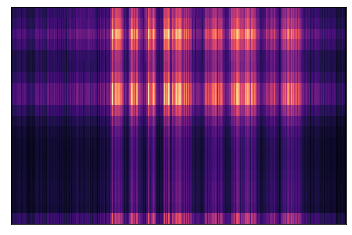

In [7]:
lr.display.specshow(mag_result**.2)

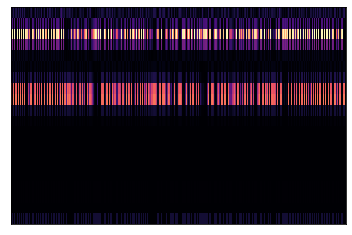

In [8]:
lr.display.specshow(np.abs(phase_result))

In [9]:
grad_0, grad_1 = np.gradient(np.abs(phase_result))
print(phase_result.shape)
print(grad_0.shape)
print(grad_1.shape)

(20, 12428)
(20, 12428)
(20, 12428)


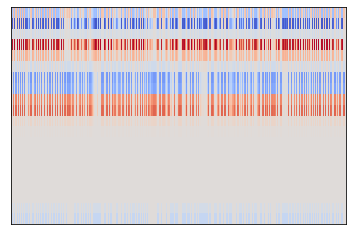

In [10]:
lr.display.specshow(grad_0)

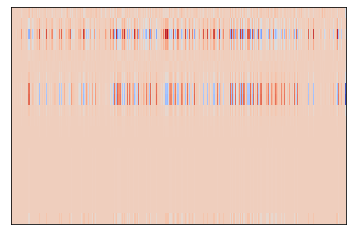

In [11]:
lr.display.specshow(grad_1)

# Desired features:

Gammatone filterbank, 50Hz-2kHz $20 \times T$

DFT (up to 500 Hz) $1 \times T$

Magnitude-sorted DFT $1 \times T$

Cepstrum $1 \times T$

Envelope Follower $1 \times T$

Time-domain signal (low-passed) $1 \times T$

Features were computed as the log-energy of frames of 64samples, with a hop size of 32

In [12]:
#gammatone filter

#Thus, an ERB Gammatone filterbank with 
#20 frequency bands
#from 50 Hz to 2 kHz
#the log-energy of frames of 64
#a hop size of 32. 
#This resulted in a 20ˆ1991 feature matrix for each 4-seconds clip

import gammatone
from gammatone import gtgram, filters

wave = test_audio
low_freq = 50
high_freq = 2000
num_freq = 20
window_s = 16
hop_s = 8

#compute filterbank
center_freqs = gammatone.filters.erb_space(low_freq=low_freq, high_freq=high_freq, num=num_freq)
fcoefs = np.flipud(gammatone.filters.make_erb_filters(sr, center_freqs))

#apply filterbank to signal
xf = gammatone.filters.erb_filterbank(wave, fcoefs)
xe = np.power(xf, 2)

#apply windowing to signal
filterbank_cols = xe.shape[1]
ncols = (1 + int(np.floor((filterbank_cols - window_s)/ hop_s)))

y = np.zeros((num_freq, ncols))
    
for cnum in range(ncols):
    segment = xe[:, cnum * hop_s + np.arange(window_s)]
    y[:, cnum] = np.sqrt(segment.mean(1))
    
features = y
feature_len = features.shape[1]

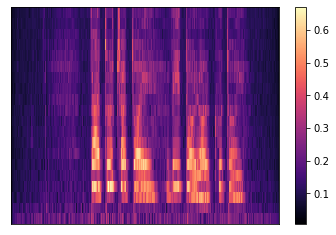

In [13]:
gt_gram = gammatone.gtgram.gtgram(wave, sr, window_s/sr, hop_s/sr, 20, 50)
lr.display.specshow(gt_gram**.2)
plt.colorbar()

In [14]:
features.shape

(20, 12430)

(20, 12430)


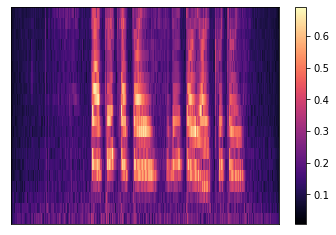

In [15]:
lr.display.specshow(features**.2)
print(features.shape)
plt.colorbar()

(1025, 195)


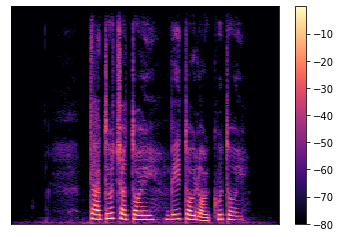

In [16]:
#compare to spectrogram, just in case
D = lr.stft(wave)
S_db = lr.amplitude_to_db(np.abs(D), ref=np.max)
plt.figure()
lr.display.specshow(S_db)
plt.colorbar()
print(D.shape)

In [17]:
#dft
dft = sp.fft.fft(wave)
print(dft.shape)
dft_limited = dft[:feature_len]
print(dft_limited.shape)
features_2 = np.vstack((features, dft_limited))
print(features_2.shape)

(99448,)
(12430,)
(21, 12430)


In [18]:
#magnitude sorted DFT
ms_dft = np.sort(dft_limited)
features_3 = np.vstack((features_2, ms_dft))
print(features_3.shape)

(22, 12430)


In [19]:
#cepstrum

#compute logarithm of spectral amplitude of dft
log_spec_amp = np.log(np.power(np.abs(dft_limited),2))
#compute ifft of log spectral amplitude
ifft_lsp = sp.fft.ifft(log_spec_amp)
#compute magnitude of ifft
cepstrum = np.power(np.abs(ifft_lsp),2)
print(cepstrum.shape)

features_4 = np.vstack((features_3, cepstrum[:feature_len]))
print(features_4.shape)

(12430,)
(23, 12430)


(24, 12430)


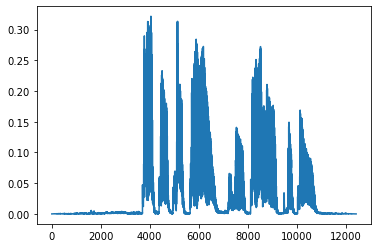

In [20]:
#envelope follower
log_energy = lr.feature.rms(y=wave, frame_length=window_s, hop_length=hop_s)
plt.plot(log_energy.flatten())
features_5 = np.vstack((features_4, log_energy.flatten()[:feature_len]))
print(features_5.shape)

In [21]:
#td signal low-passed
#TODO

In [22]:
class _featurizer:
    def __init__(self, input_len, sr=16000):
        self.input_len = input_len
        self.sr = sr

        self.out_shape = None
        
        #run process to get out_shape
        _ = self.process(np.ones(input_len))
        print("Feature output shape: {}".format(self.out_shape))

    def process(self, wave):
        pass

class featurizer_block(_featurizer):
    def __init__(self, input_len, featurizations=None, sr=16000,
                 out_len=None, normed=True):
        self.featurizations = featurizations
        self.input_len = input_len
        self.sr = sr
        self.normed=normed
        self.out_len = out_len
        self.out_shape = None
        
        #run process to get out_shape
        _ = self.process(np.ones(input_len))
        print("Featurization block output shape: {}".format(self.out_shape))
        
    def process(self, wave):
        out_feature = None
        for feat_func in self.featurizations:
            feature = feat_func.process(wave)
            feature = feature[:,:self.out_len]
            if self.normed:
                feature = feature/max(feature.flatten())
            if out_feature is None:
                out_feature = feature
            else:
                out_feature = np.vstack((out_feature,feature))
        
        if self.out_shape is None:
            self.out_shape = out_feature.shape
        return out_feature
        
    
from gammatone import gtgram, filters

class gammatone_feat(_featurizer):
    def __init__(self, input_len, sr=16000, low_freq=50, high_freq=2000, num_freq=20,
                 window_s=64, hop_s=32):
        
        self.input_len = input_len
        self.sr = sr
        self.low_freq = low_freq
        self.high_freq = high_freq
        self.num_freq = num_freq
        self.window_s = window_s
        self.hop_s = hop_s
        
        self.out_shape = None

        #compute filterbank
        self.center_freqs = gammatone.filters.erb_space(low_freq=self.low_freq,
                                                   high_freq=self.high_freq,
                                                   num=self.num_freq)
        
        self.fcoefs = np.flipud(gammatone.filters.make_erb_filters(self.sr, self.center_freqs))

        #run process to get out_shape
        _ = self.process(np.ones(input_len))
        print("Gammatone output shape: {}".format(self.out_shape))
        
    def process(self, wave):
        #apply filterbank to signal
        xf = gammatone.filters.erb_filterbank(wave, self.fcoefs)
        xe = np.power(xf, 2)

        #apply windowing to signal
        filterbank_cols = xe.shape[1]
        ncols = (1 + int(np.floor((filterbank_cols - self.window_s)/ self.hop_s)))

        y = np.zeros((self.num_freq, ncols))

        for cnum in range(ncols):
            segment = xe[:, cnum * hop_s + np.arange(window_s)]
            y[:, cnum] = np.sqrt(segment.mean(1))

        features = y
        
        if self.out_shape is None:
            self.out_shape = features.shape
        return features

class dft_feat(_featurizer):
    def __init__(self, input_len, sr=16000, out_len=None, is_sorted=False):
        self.input_len = input_len
        self.sr = sr
        self.out_len = out_len
        self.is_sorted = is_sorted
        
        self.out_shape = None
        #run process to get out_shape
        _ = self.process(np.ones(input_len))
        print("Dft output shape: {}".format(self.out_shape))

    
    def process(self, wave):
        dft = sp.fft.fft(wave)
        if self.out_len is not None:
            dft = dft[:self.out_len]
        if self.is_sorted:
            dft = np.sort(dft)
            
        if self.out_shape is None:
            self.out_shape = (1,len(dft))
        dft = dft.reshape(self.out_shape)
        return dft

    
class cepstrum_feat(_featurizer):
    
    def __init__(self, input_len, sr=16000, out_len=None):
        self.input_len = input_len
        self.sr = sr
        self.out_len = out_len

        self.out_shape = None
        
        #run process to get out_shape
        _ = self.process(np.ones(input_len))
        print("Ceptrum output shape: {}".format(self.out_shape))

    def process(self, wave):
        dft = sp.fft.fft(wave)
        if self.out_len is not None:
            dft = dft[:self.out_len]
        #compute logarithm of spectral amplitude of dft
        log_spec_amp = np.log(np.power(np.abs(dft),2))        
        #compute ifft of log spectral amplitude
        ifft_lsp = sp.fft.ifft(log_spec_amp)
        #compute magnitude of ifft
        cepstrum = np.power(np.abs(ifft_lsp),2)
        
        if self.out_shape is None:
            self.out_shape = (1,len(cepstrum))
        cepstrum = cepstrum.reshape(self.out_shape)            
        return cepstrum
    
class envelope_feat(_featurizer):
    def __init__(self, input_len, sr=16000, window_s=64, hop_s=32,
                 out_len=None):
        self.input_len = input_len
        self.sr = sr
        self.window_s = window_s
        self.hop_s = hop_s
        self.out_len = out_len

        self.out_shape = None
        
        #run process to get out_shape
        _ = self.process(np.ones(input_len))
        print("Envelope output shape: {}".format(self.out_shape))

    def process(self, wave):
        log_energy = lr.feature.rms(y=wave, frame_length=self.window_s,
                                    hop_length=self.hop_s)

        if self.out_len is not None:
            log_energy = log_energy[:,:self.out_len]
        
        if self.out_shape is None:
            self.out_shape = log_energy.shape
        return log_energy
    
    


In [23]:
gt_f = gammatone_feat(test_rir.shape[0])
dft_f = dft_feat(test_rir.shape[0], out_len=gt_f.out_shape[1])
dfts_f = dft_feat(test_rir.shape[0], is_sorted=True, out_len=gt_f.out_shape[1])
cepstrum_f = cepstrum_feat(test_rir.shape[0], out_len=gt_f.out_shape[1]) 
rms_f = envelope_feat(test_rir.shape[0], out_len=gt_f.out_shape[1])

Gammatone output shape: (20, 1954)
Dft output shape: (1, 1954)
Dft output shape: (1, 1954)
Ceptrum output shape: (1, 1954)
Envelope output shape: (1, 1954)


In [24]:
feats = [gt_f, dft_f, dfts_f, cepstrum_f, rms_f]
block_f = featurizer_block(test_rir.shape[0], featurizations=feats, out_len=gt_f.out_shape[1])

Featurization block output shape: (24, 1954)


In [25]:
test_feat = block_f.process(test_audio)

(20, 12430)


/scratch/ci411/.conda/envs/s3d_env/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  return f(*args, **kwargs)


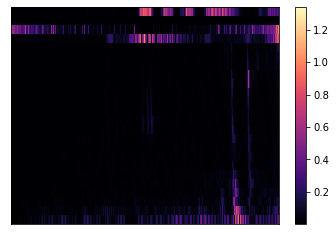

In [26]:
lr.display.specshow(test_feat)
print(features.shape)
plt.colorbar()

In [31]:
from gammatone import fftweight

class gammatone_featurizer:
    def __init__(self, input_len, feat_type, sr=16000, num_freq=20, window_s=64,\
                 hop_s=32, low_freq=50, high_freq=2000, deriv_seq=None):
        
        self.feat_type = feat_type #can be 'mag', 'phase'
        self.input_len = input_len
        self.sr = sr
        self.num_freq = num_freq
        self.window_s = window_s
        self.hop_s = hop_s
        self.low_freq = low_freq
        self.high_freq = high_freq
        self.nfft = int(2 ** (np.ceil(np.log2(2 * self.window_s))))
        self.deriv_seq = deriv_seq #list of derivatives 
                                   #(along either bin axis [0] or time axis [1])

        self.out_shape = None

        #run process to get out_shape
        _ = self.process(np.ones(input_len))
        
        print("{} features output shape: {}".format(self.feat_type, self.out_shape))

    def process(self, wave):
        weights, _ = gammatone.fftweight.fft_weights(self.nfft, self.sr, self.num_freq, 1,\
                                                     self.low_freq, self.high_freq, self.nfft/2+1)

        sgram = gammatone.fftweight.specgram(wave, self.nfft, self.sr, self.window_s, self.hop_s)
        if self.feat_type == 'mag':
            result = weights.dot(np.abs(sgram))
        elif self.feat_type == 'phase':     
            result = weights.dot(np.angle(sgram))
        
        if self.deriv_seq is not None:
            for ax in self.deriv_seq:
                result = np.gradient(result)[ax]
             
        if self.out_shape is None:
            self.out_shape = result.shape
        
        return result

In [41]:
input_shape = test_audio.shape[0]

mag_fb = gammatone_featurizer(input_shape, 'mag')

phase_fb = gammatone_featurizer(input_shape, 'phase')

phase_lf = gammatone_featurizer(input_shape, 'phase', num_freq=5,
                               low_freq=50, high_freq=500)

phase1D_lf = gammatone_featurizer(input_shape, 'phase', num_freq=5,
                               low_freq=50, high_freq=500, deriv_seq=[0])

cont_lf = gammatone_featurizer(input_shape, 'phase', num_freq=5,
                               low_freq=50, high_freq=500, deriv_seq=[0,1])

out_len = mag_fb.out_shape[1]

dft_f = dft_feat(input_shape, out_len=out_len)
dfts_f = dft_feat(input_shape, is_sorted=True, out_len=out_len)
cepstrum_f = cepstrum_feat(input_shape, out_len=out_len) 
rms_f = envelope_feat(input_shape, out_len=out_len)

lf_feats = [dft_f, dfts_f, cepstrum_f, rms_f] 
lf_feats_block = featurizer_block(input_shape, featurizations=lf_feats,
                                  out_len=out_len)


baseline = [mag_fb, lf_feats_block]

prop1 = [mag_fb, phase_lf, phase1D_lf]
prop2 = [phase_lf, phase1D_lf]
prop3 = [mag_fb, phase1D_lf]
prop4 = [mag_fb, phase_lf]

prop5 = [mag_fb, lf_feats_block, cont_lf]
prop6 = [mag_fb, phase_lf, phase1D_lf, cont_lf]

baseline_block = featurizer_block(input_shape, featurizations=baseline,
                                  out_len=out_len)
prop1_block = featurizer_block(input_shape, featurizations=prop1,
                                  out_len=out_len)
prop2_block = featurizer_block(input_shape, featurizations=prop2,
                                  out_len=out_len)
prop3_block = featurizer_block(input_shape, featurizations=prop3,
                                  out_len=out_len)
prop4_block = featurizer_block(input_shape, featurizations=prop4,
                                  out_len=out_len)
prop5_block = featurizer_block(input_shape, featurizations=prop5,
                                  out_len=out_len)
prop6_block = featurizer_block(input_shape, featurizations=prop6,
                                  out_len=out_len)

mag features output shape: (20, 3104)
phase features output shape: (20, 3104)
phase features output shape: (5, 3104)
phase features output shape: (5, 3104)
phase features output shape: (5, 3104)
Dft output shape: (1, 3104)
Dft output shape: (1, 3104)
Ceptrum output shape: (1, 3104)
Envelope output shape: (1, 3104)
Featurization block output shape: (4, 3104)
Featurization block output shape: (24, 3104)


/state/partition1/job-23556329/ipykernel_2146335/873710477.py:138: RuntimeWarning: divide by zero encountered in log
  log_spec_amp = np.log(np.power(np.abs(dft),2))
/state/partition1/job-23556329/ipykernel_2146335/873710477.py:35: RuntimeWarning: invalid value encountered in true_divide
  feature = feature/max(feature.flatten())


Featurization block output shape: (30, 3104)
Featurization block output shape: (10, 3104)
Featurization block output shape: (25, 3104)
Featurization block output shape: (25, 3104)
Featurization block output shape: (29, 3104)
Featurization block output shape: (35, 3104)


In [42]:
block_f = featurizer_block(test_rir.shape[0], featurizations=feats, out_len=gt_f.out_shape[1])

3107.75

(5, 3104)


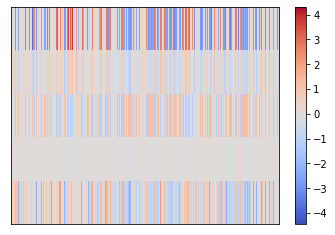

In [40]:
test_cont = cont_lf.process(test_audio)
lr.display.specshow(test_cont)
print(test_cont.shape)
plt.colorbar()